In [8]:
%%time
%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys
from dataclasses import dataclass
from pathlib import Path

# 必要なライブラリのインポート
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from dotenv import load_dotenv
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import RandomizedSearchCV, train_test_split


@dataclass
class Config:
    project_dir: Path = Path("../../")
    model_dir: Path = project_dir / "models"
    outputs_dir: Path = project_dir / "outputs"
    results_dir: Path = project_dir / "results"
    results_agg_dir: Path = results_dir / "agg"
    results_figs_dir: Path = results_dir / "figs"
    data_dir: Path = project_dir / "data"
    raw_dir: Path = data_dir / "raw"
    interim_dir: Path = data_dir / "interim"
    processed_dir: Path = data_dir / "processed"


config = Config()
sys.path.append(str(config.project_dir.resolve()))
load_dotenv()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
CPU times: user 2.11 ms, sys: 7.39 ms, total: 9.51 ms
Wall time: 28.3 ms


True

In [2]:
df_order_info_details = pd.read_csv(config.processed_dir / "order_info_details.csv")
df_reviews = pd.read_csv(
    config.interim_dir
    / "olist_order_reviews_translated_label_review_categories_merged.csv",
)
df_reviews_last = df_reviews.groupby("order_id").last().reset_index()
df_order_info_details_reviews_merged = pd.merge(
    df_order_info_details, df_reviews_last, on="order_id", how="left"
)
assert df_order_info_details_reviews_merged.shape[0] == df_order_info_details.shape[0]
for col in [
    "order_purchase_timestamp",
    "order_approved_at",
    "order_delivered_carrier_date",
    "order_delivered_customer_date",
    "order_estimated_delivery_date",
    "shipping_limit_date",
]:
    df_order_info_details_reviews_merged[col] = pd.to_datetime(
        df_order_info_details_reviews_merged[col],
        format="mixed",
    )
df_review_no_null = df_order_info_details_reviews_merged.dropna(
    subset=["review_comment_message_en"]
)
print(f"df_review_no_null.shape: {df_review_no_null.shape}")


df_review_no_null.shape: (40818, 85)


In [3]:
df_target = (
    df_review_no_null.query(
        "review_categories_str_modified in ['Delivery_Issue','Delivery_Praise'] "
    )
    .query("customer_state in ['SP','RJ']")
    .dropna(subset=["order_delivered_customer_span_hours_from_carrier"])
)
df_target["is_same_state"] = (
    df_target["customer_state"] == df_target["seller_state"]
).astype(int)
df_target["is_same_city"] = (
    df_target["customer_city"] == df_target["seller_city"]
).astype(int)
df_target["freight_ratio"] = (
    df_target["sum_freight"] / df_target["sum_price_freight_by_order"]
)

y, x = (
    df_target["order_delivered_customer_span_hours_from_carrier"],
    df_target[
        [
            "order_purchase_month",
            "customer_city",
            "customer_state",
            "sum_price",
            "sum_freight",
            # "freight_ratio",
            "sum_price_freight_by_order",
            "product_count",
            "seller_count",
            "product_photos_qty",
            "sum_product_weight_g",
            "sum_product_volume_cm3",
            "product_length_cm",
            "product_height_cm",
            "product_width_cm",
            "seller_city_count",
            "seller_state_count",
            "product_category_name_english",
            "seller_city",
            "seller_state",
            "distance_between_customer_and_seller",
            "is_same_state",
            "is_same_city",
            "total_payment_value",
            "payment_type_count",
            "most_common_payment_type",
            "highest_value_payment_type",
            "highest_payment_value",
        ]
    ],
)
categorical_features = [
    "order_purchase_month",
    "customer_city",
    "customer_state",
    "product_category_name_english",
    "seller_city",
    "seller_state",
    "most_common_payment_type",
    "highest_value_payment_type",
]

Fitting 5 folds for each of 50 candidates, totalling 250 fits


/var/folders/30/20s46n1s20jdzzh6w9vnkglw0000gn/T/ipykernel_67785/4154482183.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x[col] = x[col].astype("category")
/var/folders/30/20s46n1s20jdzzh6w9vnkglw0000gn/T/ipykernel_67785/4154482183.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x[col] = x[col].astype("category")
/var/folders/30/20s46n1s20jdzzh6w9vnkglw0000gn/T/ipykernel_67785/4154482183.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

[CV] END bagging_fraction=0.8, bagging_freq=10, feature_fraction=0.8, learning_rate=0.1, max_depth=20, min_child_samples=10, n_estimators=200, num_leaves=100, reg_alpha=0.1, reg_lambda=0.5; total time=  23.6s
[CV] END bagging_fraction=0.8, bagging_freq=10, feature_fraction=0.8, learning_rate=0.1, max_depth=20, min_child_samples=10, n_estimators=200, num_leaves=100, reg_alpha=0.1, reg_lambda=0.5; total time=  23.9s
[CV] END bagging_fraction=0.8, bagging_freq=10, feature_fraction=0.8, learning_rate=0.1, max_depth=20, min_child_samples=10, n_estimators=200, num_leaves=100, reg_alpha=0.1, reg_lambda=0.5; total time=  24.2s
[CV] END bagging_fraction=0.8, bagging_freq=10, feature_fraction=0.8, learning_rate=0.1, max_depth=20, min_child_samples=10, n_estimators=200, num_leaves=100, reg_alpha=0.1, reg_lambda=0.5; total time=  24.3s
[CV] END bagging_fraction=0.8, bagging_freq=10, feature_fraction=0.8, learning_rate=0.1, max_depth=20, min_child_samples=10, n_estimators=200, num_leaves=100, reg_a

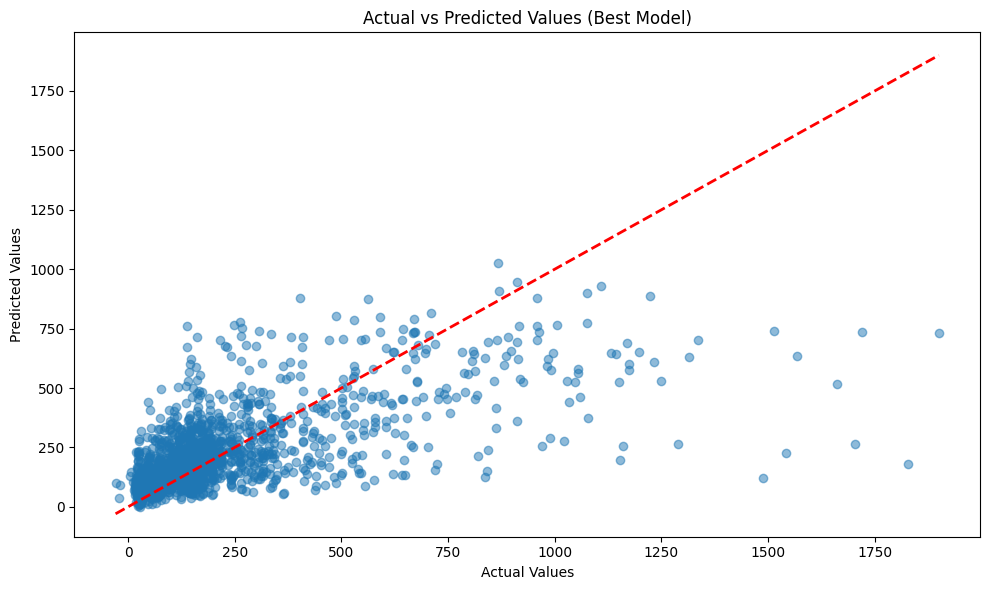


Top 10 most important features:
                                 feature  importance
0                   order_purchase_month        2390
19  distance_between_customer_and_seller        1856
16         product_category_name_english        1461
17                           seller_city        1451
1                          customer_city        1435
4                            sum_freight        1373
10                sum_product_volume_cm3        1116
9                   sum_product_weight_g         871
12                     product_height_cm         819
11                     product_length_cm         713


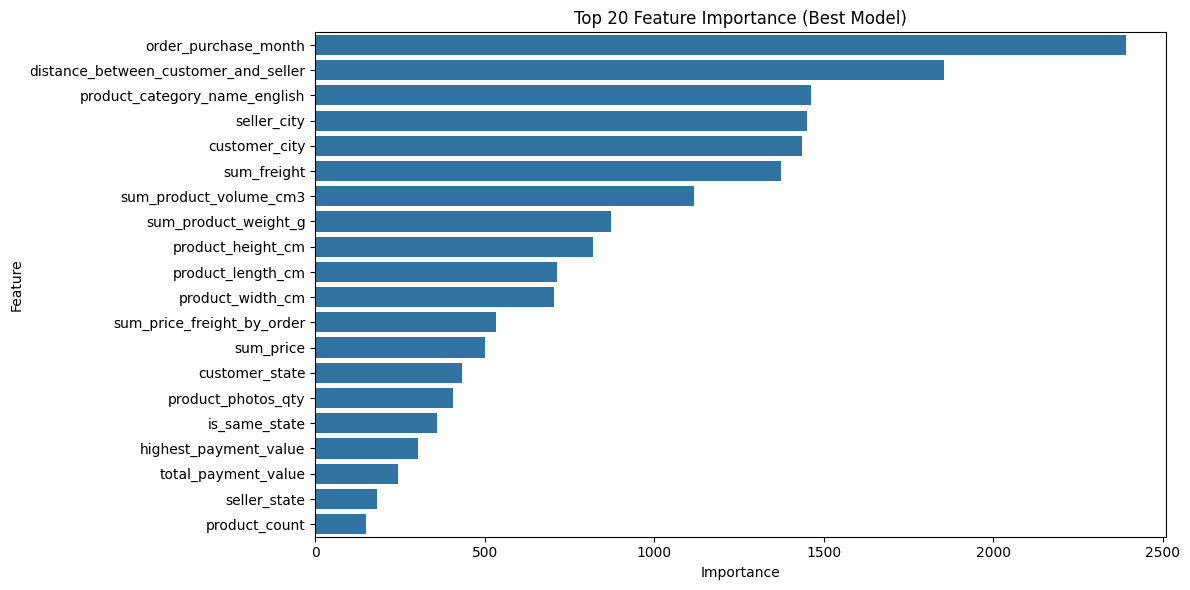

In [12]:
# カテゴリカル変数の型変換
for col in categorical_features:
    if col in x.columns:
        x[col] = x[col].astype("category")

# データを訓練セットとテストセットに分割
X_train, X_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42
)

# パラメータの探索範囲を定義
param_dist = {
    "num_leaves": [31, 50, 100, 200],
    "learning_rate": [0.01, 0.05, 0.1],
    "n_estimators": [100, 200, 500, 1000],
    "feature_fraction": [0.7, 0.8, 0.9, 1.0],
    "min_child_samples": [10, 20, 30, 50],
    "max_depth": [-1, 5, 10, 20],
    "reg_alpha": [0, 0.1, 0.5, 1.0],
    "reg_lambda": [0, 0.1, 0.5, 1.0],
    "bagging_fraction": [0.8, 0.9, 1.0],
    "bagging_freq": [0, 5, 10],
}

# LGBMRegressorの初期化
lgb_reg = LGBMRegressor(
    objective="regression",
    metric="rmse",
    boosting_type="gbdt",
    verbose=-1,
    random_state=42,
)

# ランダムサーチの実行
random_search = RandomizedSearchCV(
    estimator=lgb_reg,
    param_distributions=param_dist,
    n_iter=50,  # 試行回数
    scoring="neg_root_mean_squared_error",
    cv=5,
    random_state=42,
    n_jobs=-1,
    verbose=2,
)

# モデルの学習
random_search.fit(X_train, y_train, categorical_feature=categorical_features)

print("\nBest parameters:", random_search.best_params_)
print("Best cross-validation RMSE: {:.4f}".format(-random_search.best_score_))

# 最良のモデルを使用して予測
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)

# モデルの評価
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
print(f"\nTest set RMSE: {rmse:.4f}")
print(f"Test set R2 Score: {r2:.4f}")

# 実測値と予測値の散布図
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--", lw=2)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted Values (Best Model)")
plt.tight_layout()
plt.show()

# 特徴量の重要度を表示
importance = pd.DataFrame(
    {"feature": X_train.columns, "importance": best_model.feature_importances_}
)
importance = importance.sort_values("importance", ascending=False)
print("\nTop 10 most important features:")
print(importance.head(10))

# 特徴量重要度の可視化
plt.figure(figsize=(12, 6))
sns.barplot(data=importance.head(20), x="importance", y="feature")
plt.title("Top 20 Feature Importance (Best Model)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

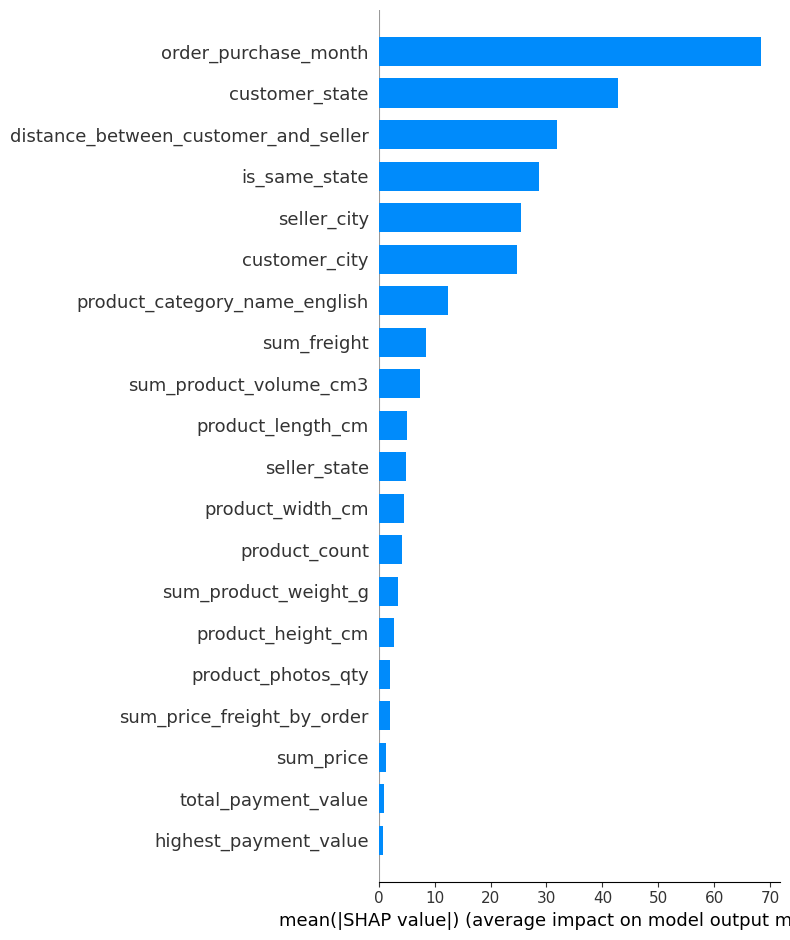

In [13]:
# SHAP値の計算
import shap

explainer = shap.TreeExplainer(best_model)  # TreeExplainerを使う
shap_values = explainer.shap_values(X_train)

# 回帰問題の場合は、shap_valuesは2次元配列なのでaxis=2での平均は不要
shap_explanation = shap.Explanation(
    values=shap_values,  # axis=2での平均を削除
    feature_names=X_train.columns,  # 特徴量の名前
    data=X_train.values,  # 特徴量データ (NumPy配列)
)

# SHAP値の可視化
shap.initjs()
shap.summary_plot(shap_values, X_train, plot_type="bar")


In [12]:
from src.interpreter.interpreter import (
    IndividualConditionalExpectation,
    PartialDependence,
)

pdp = PartialDependence(
    model=best_model,
    X=X_train,
    var_names=X_train.columns,
    pred_type="regression",
    label_list=None,
)
ice_distance_between_customer_and_seller = IndividualConditionalExpectation(
    model=best_model,
    X=X_train,
    var_names=X_train.columns,
    pred_type="regression",
    label_list=None,
)
ice_distance_between_customer_and_seller.individual_conditional_expectation(
    var_name="distance_between_customer_and_seller", n_grid=10
)

In [15]:
ice_distance_between_customer_and_seller.df_ice

,distance_between_customer_and_seller,instance,ice,ice_diff
0,0.000000,0,85.234204,0.000000
1,266.992214,0,110.259186,25.024983
2,533.984428,0,110.259186,25.024983
3,800.976642,0,110.259186,25.024983
4,1067.968856,0,110.259186,25.024983
...,...,...,...,...
64875,1334.961070,6487,510.869738,229.796557
64876,1601.953284,6487,510.869738,229.796557
64877,1868.945498,6487,510.869738,229.796557
64878,2135.937712,6487,510.869738,229.796557


<Axes: xlabel='distance_between_customer_and_seller', ylabel='ice'>

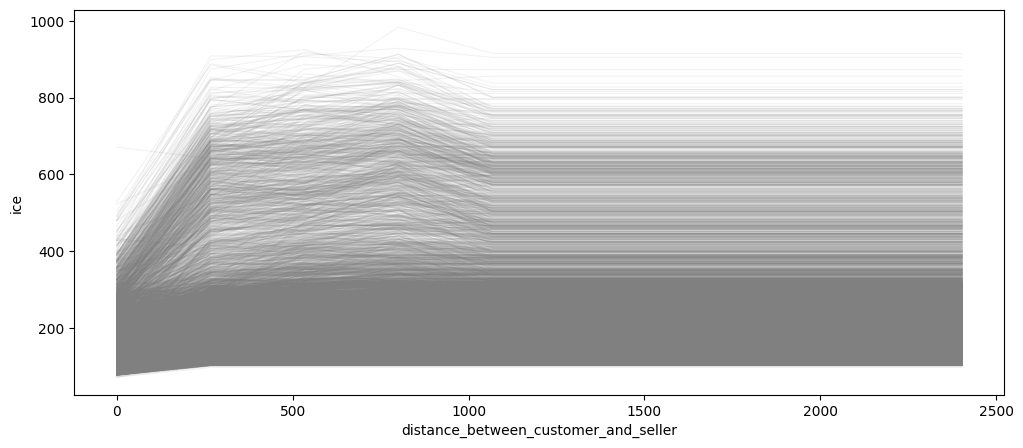

In [ ]:
# fig, ax = plt.subplots(figsize=(12, 5))
# sns.lineplot(
#     x=ice_distance_between_customer_and_seller.target_var_name,
#     y="ice",
#     units="instance",
#     data=ice_distance_between_customer_and_seller.df_ice,
#     lw=0.8,
#     alpha=0.1,
#     estimator=None,
#     zorder=1,
#     ax=ax,
#     color="gray",
# )

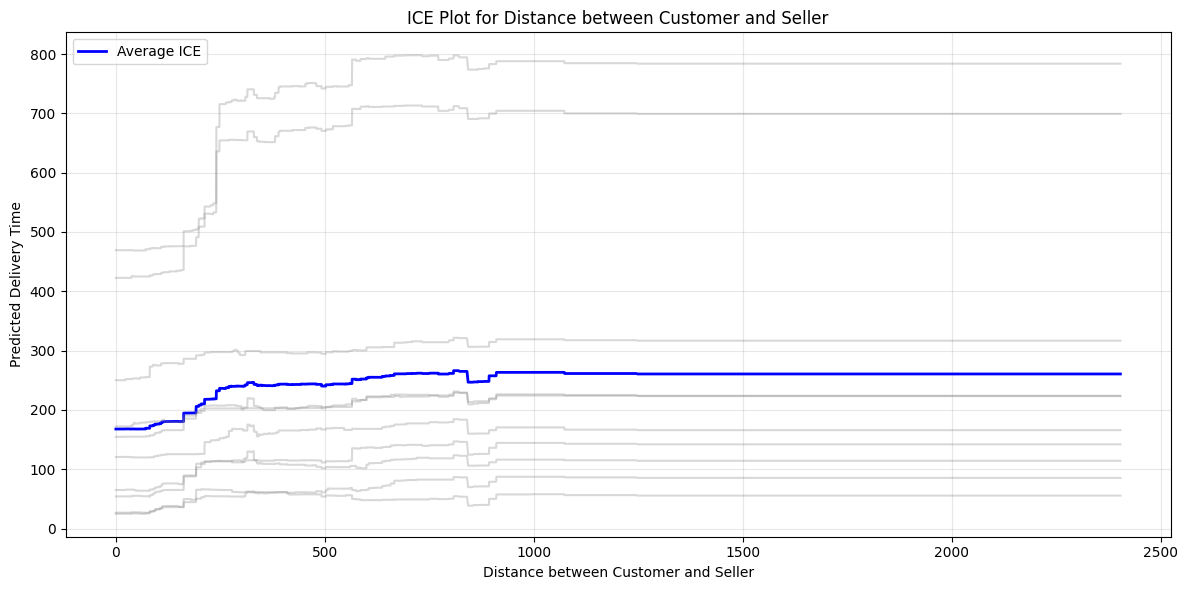

In [14]:
# ICEプロットの作成
plt.figure(figsize=(12, 6))

# 特徴量の値をソート
feature_values = np.sort(X_train["distance_between_customer_and_seller"].unique())
ice_values = []

# 各サンプルについてICE値を計算
for i in range(min(100, len(X_train))):  # 計算時間を考慮して100サンプルに制限
    # データフレームとして保持
    sample = X_train.iloc[[i]].copy()
    ice_sample = []

    for value in feature_values:
        temp_sample = sample.copy()
        temp_sample["distance_between_customer_and_seller"] = value
        pred = best_model.predict(temp_sample)
        ice_sample.append(pred[0])

    ice_values.append(ice_sample)

# ICEプロットの描画
ice_values = np.array(ice_values)
mean_ice = np.mean(ice_values, axis=0)

plt.plot(feature_values, mean_ice, "b-", linewidth=2, label="Average ICE")
for i in range(min(10, len(ice_values))):
    plt.plot(feature_values, ice_values[i], "gray", alpha=0.3)

plt.xlabel("Distance between Customer and Seller")
plt.ylabel("Predicted Delivery Time")
plt.title("ICE Plot for Distance between Customer and Seller")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 売れているカテゴリーに限定して

Fitting 5 folds for each of 50 candidates, totalling 250 fits


/var/folders/30/20s46n1s20jdzzh6w9vnkglw0000gn/T/ipykernel_40220/3801953751.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x[col] = x[col].astype("category")
/var/folders/30/20s46n1s20jdzzh6w9vnkglw0000gn/T/ipykernel_40220/3801953751.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x[col] = x[col].astype("category")
/var/folders/30/20s46n1s20jdzzh6w9vnkglw0000gn/T/ipykernel_40220/3801953751.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

[CV] END bagging_fraction=0.8, bagging_freq=10, feature_fraction=0.8, learning_rate=0.1, max_depth=20, min_child_samples=10, n_estimators=200, num_leaves=100, reg_alpha=0.1, reg_lambda=0.5; total time=  14.9s
[CV] END bagging_fraction=0.8, bagging_freq=10, feature_fraction=0.8, learning_rate=0.1, max_depth=20, min_child_samples=10, n_estimators=200, num_leaves=100, reg_alpha=0.1, reg_lambda=0.5; total time=  15.8s
[CV] END bagging_fraction=0.8, bagging_freq=10, feature_fraction=0.8, learning_rate=0.1, max_depth=20, min_child_samples=10, n_estimators=200, num_leaves=100, reg_alpha=0.1, reg_lambda=0.5; total time=  15.9s
[CV] END bagging_fraction=0.8, bagging_freq=10, feature_fraction=0.8, learning_rate=0.1, max_depth=20, min_child_samples=10, n_estimators=200, num_leaves=100, reg_alpha=0.1, reg_lambda=0.5; total time=  16.0s
[CV] END bagging_fraction=0.8, bagging_freq=10, feature_fraction=0.8, learning_rate=0.1, max_depth=20, min_child_samples=10, n_estimators=200, num_leaves=100, reg_a

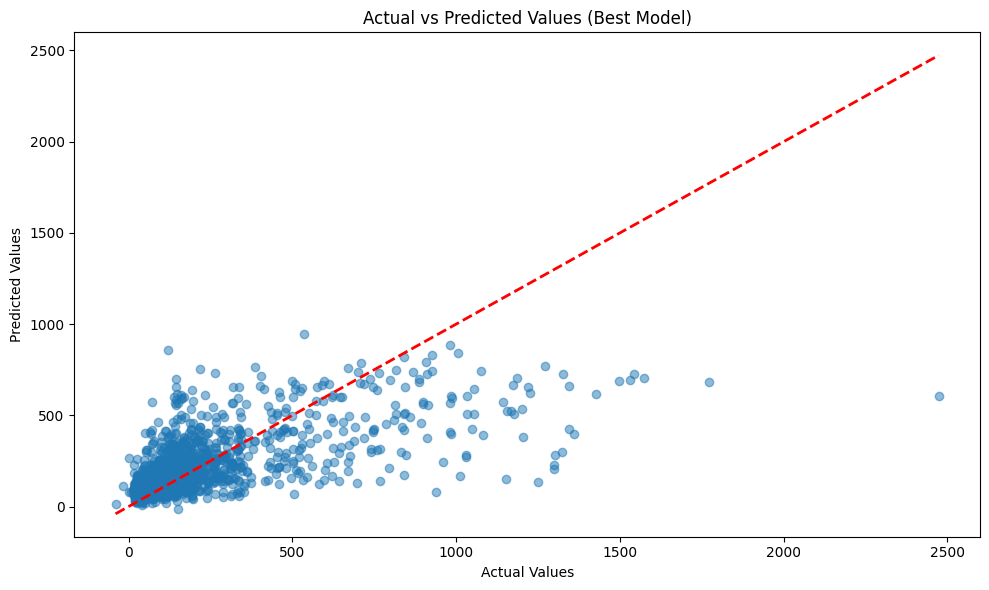


Top 10 most important features:
                                 feature  importance
0                   order_purchase_month        2229
19  distance_between_customer_and_seller        2217
1                          customer_city        1368
4                            sum_freight        1254
17                           seller_city        1241
16         product_category_name_english        1105
9                   sum_product_weight_g         981
10                sum_product_volume_cm3         950
12                     product_height_cm         726
11                     product_length_cm         723


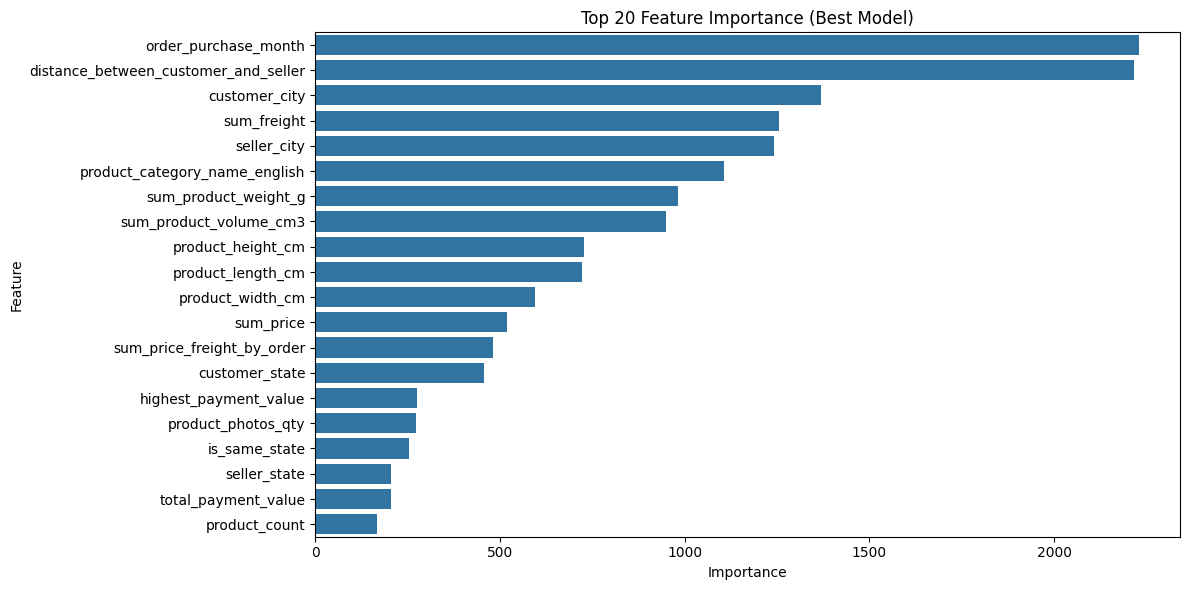

In [50]:
# 必要なライブラリのインポート
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import RandomizedSearchCV, train_test_split

top_sales_product_category_name_english_list = list(
    df_order_info_details_reviews_merged.groupby("product_category_name_english")[
        "sum_price"
    ]
    .sum()
    .sort_values(ascending=False)
    .index[:15]
)
df_target_selected = df_target.query(
    "product_category_name_english in @top_sales_product_category_name_english_list"
)

y, x = (
    df_target_selected["order_delivered_customer_span_hours_from_carrier"],
    df_target_selected[
        [
            "order_purchase_month",
            "customer_city",
            "customer_state",
            "sum_price",
            "sum_freight",
            # "freight_ratio",
            "sum_price_freight_by_order",
            "product_count",
            "seller_count",
            "product_photos_qty",
            "sum_product_weight_g",
            "sum_product_volume_cm3",
            "product_length_cm",
            "product_height_cm",
            "product_width_cm",
            "seller_city_count",
            "seller_state_count",
            "product_category_name_english",
            "seller_city",
            "seller_state",
            "distance_between_customer_and_seller",
            "is_same_state",
            "is_same_city",
            "total_payment_value",
            "payment_type_count",
            "most_common_payment_type",
            "highest_value_payment_type",
            "highest_payment_value",
        ]
    ],
)
categorical_features = [
    "order_purchase_month",
    "customer_city",
    "customer_state",
    "product_category_name_english",
    "seller_city",
    "seller_state",
    "most_common_payment_type",
    "highest_value_payment_type",
]

# カテゴリカル変数の型変換
for col in categorical_features:
    if col in x.columns:
        x[col] = x[col].astype("category")

# データを訓練セットとテストセットに分割
X_train, X_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42
)

# パラメータの探索範囲を定義
param_dist = {
    "num_leaves": [31, 50, 100, 200],
    "learning_rate": [0.01, 0.05, 0.1],
    "n_estimators": [100, 200, 500, 1000],
    "feature_fraction": [0.7, 0.8, 0.9, 1.0],
    "min_child_samples": [10, 20, 30, 50],
    "max_depth": [-1, 5, 10, 20],
    "reg_alpha": [0, 0.1, 0.5, 1.0],
    "reg_lambda": [0, 0.1, 0.5, 1.0],
    "bagging_fraction": [0.8, 0.9, 1.0],
    "bagging_freq": [0, 5, 10],
}

# LGBMRegressorの初期化
lgb_reg = LGBMRegressor(
    objective="regression",
    metric="rmse",
    boosting_type="gbdt",
    verbose=-1,
    random_state=42,
)

# ランダムサーチの実行
random_search = RandomizedSearchCV(
    estimator=lgb_reg,
    param_distributions=param_dist,
    n_iter=50,  # 試行回数
    scoring="neg_root_mean_squared_error",
    cv=5,
    random_state=42,
    n_jobs=-1,
    verbose=2,
)

# モデルの学習
random_search.fit(X_train, y_train, categorical_feature=categorical_features)

# 最良のパラメータとスコアを表示
print("\nBest parameters:", random_search.best_params_)
print("Best cross-validation RMSE: {:.4f}".format(-random_search.best_score_))

# 最良のモデルを使用して予測
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)

# モデルの評価
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
print(f"\nTest set RMSE: {rmse:.4f}")
print(f"Test set R2 Score: {r2:.4f}")

# 実測値と予測値の散布図
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--", lw=2)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted Values (Best Model)")
plt.tight_layout()
plt.show()

# 特徴量の重要度を表示
importance = pd.DataFrame(
    {"feature": X_train.columns, "importance": best_model.feature_importances_}
)
importance = importance.sort_values("importance", ascending=False)
print("\nTop 10 most important features:")
print(importance.head(10))

# 特徴量重要度の可視化
plt.figure(figsize=(12, 6))
sns.barplot(data=importance.head(20), x="importance", y="feature")
plt.title("Top 20 Feature Importance (Best Model)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

In [51]:
import shap

In [54]:
shap_values.shape

(5059, 27)

In [58]:
product_category_name_sorted = (
    df_order_info_details_reviews_merged.groupby("product_category_name_english")[
        "order_id"
    ]
    .nunique()
    .sort_values(ascending=False)
    .index
)

df_target.groupby(["order_purchase_month", "product_category_name_english"])[
    "order_delivered_customer_span_hours_from_carrier"
].mean().reindex(product_category_name_sorted, level=1)

order_purchase_month  product_category_name_english        
2016-09               health_beauty                             38.595833
2016-10               bed_bath_table                           150.330833
                      health_beauty                            106.434136
                      sports_leisure                           128.799722
                      computers_accessories                    147.131667
                                                                  ...    
2018-08               small_appliances_home_oven_and_coffee     79.582593
                      cine_photo                                28.615556
                      party_supplies                           178.664444
                      music                                     40.292500
                      diapers_and_hygiene                       96.327500
Name: order_delivered_customer_span_hours_from_carrier, Length: 832, dtype: float64

In [ ]:
df_target["review_categories_str_modified_Delivery_Issue"] = df_target[
    "review_categories_str_modified"
].apply(lambda x: 1 if x == "Delivery_Issue" else 0)
df_target["review_categories_str_modified_Delivery_Praise"] = df_target[
    "review_categories_str_modified"
].apply(lambda x: 1 if x == "Delivery_Praise" else 0)


In [66]:
df_target.groupby(
    [
        "product_category_name_english",
        "order_purchase_month",
        "review_categories_str_modified",
    ]
).agg(
    {
        "order_delivered_customer_span_hours_from_carrier": "mean",
        "distance_between_customer_and_seller": "mean",
        "order_id": "count",
        # "review_categories_str_modified_Delivery_Issue": "sum",
        # "review_categories_str_modified_Delivery_Praise": "sum",
        "freight_value": "mean",
        "price": "mean",
        "sum_price_freight_by_order": "mean",
    }
).reindex(product_category_name_sorted, level=0).to_csv(
    config.results_agg_dir
    / "df_target_groupby_order_purchase_month_product_category_name_english.csv"
)